In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import model_cifar
import copy
from sklearn.decomposition import PCA
from scipy.interpolate import griddata

import plotly.graph_objects as go

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512,
                                         shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def train_store_model_params(model, trainloader, epochs, trajecory_points_epoch, optimizer, scheduler,  criterion):
    '''
    Train the model and store the model parameters at the end of each epoch
    
    returns:
        model_param: list of model parameters at the end of each epoch
    '''
    model_param = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(tqdm(trainloader, 0)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if ((i+1) % trajecory_points_epoch == 0) and epochs-epoch < 10:
                params = list(model.parameters())
                params_vector = torch.nn.utils.parameters_to_vector(params).detach().cpu().numpy()
                model_param.append(params_vector)
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / len(trainloader)))
        scheduler.step()
        if epochs-epoch < 10:
            params = list(model.parameters())
            params_vector = torch.nn.utils.parameters_to_vector(params).detach().cpu().numpy()
            model_param.append(params_vector)
    return model_param


In [4]:
def compute_PCA(trajectory, normalize=True):
    '''
    Perform PCA on the trajectory
    
    args:
        trajectory: trajectory of model parameters (param_model, num_points)
    
    returns:
        X_pca: transformed data
    '''
    center_trajectory = trajectory[:,:-1]
    std_center_trajectory = np.std(center_trajectory, axis=1)
    normalized_trajectory = center_trajectory / std_center_trajectory.reshape(-1, 1)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(normalized_trajectory)
    print("Explained Variance Ratio:", pca.explained_variance_ratio_)
    print("Transformed Data Shape:", X_pca.shape)
    if normalize:
        X_pca[:,0] = X_pca[:,0] * std_center_trajectory
        X_pca[:,1] = X_pca[:,1] * std_center_trajectory
    return X_pca, pca


In [5]:
def compute_loss_grid(x_steps, y_steps, X_pca, trajectory, model, criterion, testloader):
    '''
    Compute the loss grid
    
    args:
        x_steps: steps in x direction np.array of shape (steps,)
        y_steps: steps in y direction np.array of shape (steps,)
        X_pca: transformed data 
        trajectory : List of model parameters
        model: model
        criterion: loss function
        testloader: test data loader
    
    returns:
        losses: loss grid np.array of shape (steps, steps) containing loss values a each grid point
    '''
    losses = np.zeros((len(x_steps), len(y_steps)))
    inputs, labels = next(iter(testloader))
    inputs, labels = inputs.to(device), labels.to(device)
    # var_center_trajectory = np.var(trajectory[:-1].T, axis=1)
    dir_one, dir_two = X_pca[:, 0] , X_pca[:, 1] 
    for i,alpha in enumerate(x_steps):
        for j, beta in enumerate(y_steps):
            new_params = copy.deepcopy(trajectory[-1])
            new_params += alpha * dir_one + beta * dir_two
            new_params = torch.from_numpy(new_params).to(device)
            torch.nn.utils.vector_to_parameters(new_params, model.parameters())
            with torch.no_grad():
                loss = criterion(model(inputs), labels).item()
                losses[i, j] = loss
                print(f'i: {i}, j: {j}, loss: {loss}')
    return losses

def compute_accuracy_grid(x_steps, y_steps, X_pca, trajectory, model, testloader):
    '''
    Compute the accuracy grid
    
    args:
        x_steps: steps in x direction np.array of shape (steps,)
        y_steps: steps in y direction np.array of shape (steps,)
        X_pca: transformed data 
        trajectory : List of model parameters
        model: model
        testloader: test data loader
    
    returns:
        accuracies: accuracy grid np.array of shape (steps, steps) containing accuracy values a each grid point
    '''
    accuracies = np.zeros((len(x_steps), len(y_steps)))
    inputs, labels = next(iter(testloader))
    inputs, labels = inputs.to(device), labels.to(device)
    dir_one, dir_two = X_pca[:, 0] , X_pca[:, 1] 
    for i,alpha in enumerate(x_steps):
        for j, beta in enumerate(y_steps):
            new_params = copy.deepcopy(trajectory[-1])
            new_params += alpha * dir_one + beta * dir_two
            new_params = torch.from_numpy(new_params).to(device)
            torch.nn.utils.vector_to_parameters(new_params, model.parameters())
            with torch.no_grad():
                correct = 0
                total = 0
                for batch_id, data in enumerate(testloader):
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    if batch_id == 2:
                        break
                accuracy = correct / total
                accuracies[i, j] = accuracy
                print(f'i: {i}, j: {j}, accuracy: {accuracy}')
    return accuracies

In [6]:
def project_trajectory_on_dir(dir_one, dir_two, trajectory):
    '''
    Project the trajectory on the two directions
    
    args:
        dir_one: direction 1
        dir_two: direction 2
        trajectory: trajectory (num_param, num_points)
    
    returns:
        projection_dir_one: projection on direction 1
        projection_dir_two: projection on direction 2
    '''
    # var_center_trajectory = np.var(trajectory, axis=1) # (num_param, 1)
    # dir_one = dir_one * var_center_trajectory # (num_param, 1)
    # dir_two = dir_two * var_center_trajectory # (num_param, 1)
    
    norm_dir_one = np.linalg.norm(dir_one) # scalar
    norm_dir_two = np.linalg.norm(dir_two) # scalar

    projection_dir_one = trajectory.T @ dir_one / norm_dir_one # (num_points, 1)
    projection_dir_two = trajectory.T @ dir_two / norm_dir_two # (num_points, 1)
    
    return projection_dir_one , projection_dir_two

In [7]:
def plot_optimization_path_3d(loss_data, x_steps, y_steps, projection_dir_one, projection_dir_two, pca, z_axis = 'loss'):
    X = x_steps
    Y = y_steps

    # Find the range of your z values
    z_min, z_max = np.min(loss_data), np.max(loss_data)
    
    # # Create a grid of (x, y) coordinates for the landscape
    grid_x, grid_y = np.meshgrid(X, Y)
    # Interpolate the landscape values for the given (x, y) coordinates
    z_values_interp = griddata(points = np.column_stack((grid_x.flatten(), grid_y.flatten()))
                               , values = loss_data.flatten()
                               , xi = np.column_stack((projection_dir_one, projection_dir_two))
                               , method='linear')
    # Create layout with adjusted scale
    layout = go.Layout(
        scene=dict(
            aspectmode="manual",  # Set aspect mode to manual
            aspectratio=dict(x=1, y=1, z=0.6),  # Set aspect ratios for x, y, and z
            zaxis=dict(range=[z_min, z_max ])  # Set the range for the z-axis
        ),
        width=800,  
        height=800  
    )
    # mask point in projection direction outside of x_steps
    mask = (projection_dir_one >= X[0]) & (projection_dir_one <= X[-1]) & (projection_dir_two >= Y[0]) & (projection_dir_two <= Y[-1])
    projection_dir_one = projection_dir_one[mask]
    projection_dir_two = projection_dir_two[mask]
    z_values_interp = z_values_interp[mask]
    
    # Create figure without the trace_surface
    fig = go.Figure(layout=layout)
    # Add the surface trace to the figure
    fig.add_trace(go.Surface(x=X, y=Y, z=loss_data, name='Loss Landscape', colorscale='Viridis',
                             contours = {
                                    "z": {"show": True, "start": z_min, "end": z_max, "size": 0.1, "color": 'white'}
                             }))

    # Add the scatter plot for the path with interpolated z values
    trace_path = go.Scatter3d(x=projection_dir_one, y=projection_dir_two, z=z_values_interp.flatten(),
                              mode='markers+lines', marker=dict(size=3, color='red'), line=dict(width=5, color='red'), name='Optimization Path')
    
    # Add the trace to the figure
    fig.add_trace(trace_path)
    fig.update_scenes(zaxis_title_text=z_axis)
    fig.update_scenes(xaxis_title_text=f'Pca 1 var {pca.explained_variance_ratio_[0]:.2f}')
    fig.update_scenes(yaxis_title_text=f'Pca 2 var {pca.explained_variance_ratio_[1]:.2f}')
    #change x axis range
    fig.update_layout(scene_xaxis_range=[X[0], X[-1]])
    fig.update_layout(scene_yaxis_range=[Y[0], Y[-1]])
    
    fig.show()

In [8]:
def plot_2D_optimization_path(loss_data, x_steps, y_steps, projection_dir_one, projection_dir_two, pca):
    X = x_steps
    Y = y_steps
    
    grid_x, grid_y = np.meshgrid(x_steps, y_steps)
    z_interpoltae = griddata(points = np.column_stack((grid_x.flatten(), grid_y.flatten())),
                             values = loss_data.flatten(), 
                             xi = np.column_stack((projection_dir_one, projection_dir_two)), 
                             method='linear')
    # mask point in projection direction outside of x_steps
    mask = (projection_dir_one >= X[0]) & (projection_dir_one <= X[-1]) & (projection_dir_two >= Y[0]) & (projection_dir_two <= Y[-1])
    projection_dir_one = projection_dir_one[mask]
    projection_dir_two = projection_dir_two[mask]
    z_interpoltae = z_interpoltae[mask]
    plt.contour(x_steps, y_steps, loss_data, levels=30)
    plt.plot(projection_dir_one, projection_dir_two, 'r')
    plt.xlabel(f'Pca 1 var {pca.explained_variance_ratio_[0]:.2f}')
    plt.ylabel(f'Pca 2 var {pca.explained_variance_ratio_[1]:.2f}')
    plt.show()

In [9]:
resnet = model_cifar.ResNet56_noshort().to(device)
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 40, gamma=0.1)
epochs = 40
point_per_epoch = len(trainloader)//5

In [10]:
trajectory = train_store_model_params(resnet, trainloader, epochs, point_per_epoch, optimizer, scheduler, criterion)

100%|██████████| 391/391 [00:51<00:00,  7.54it/s]


[1,   391] loss: 2.304


100%|██████████| 391/391 [00:42<00:00,  9.09it/s]


[2,   391] loss: 2.262


100%|██████████| 391/391 [00:42<00:00,  9.12it/s]


[3,   391] loss: 2.132


100%|██████████| 391/391 [00:42<00:00,  9.20it/s]


[4,   391] loss: 1.927


100%|██████████| 391/391 [00:42<00:00,  9.12it/s]


[5,   391] loss: 1.797


100%|██████████| 391/391 [00:43<00:00,  9.08it/s]


[6,   391] loss: 1.718


100%|██████████| 391/391 [00:42<00:00,  9.18it/s]


[7,   391] loss: 1.654


100%|██████████| 391/391 [00:43<00:00,  8.97it/s]


[8,   391] loss: 1.595


100%|██████████| 391/391 [00:43<00:00,  9.03it/s]


[9,   391] loss: 1.525


100%|██████████| 391/391 [00:43<00:00,  9.01it/s]


[10,   391] loss: 1.468


100%|██████████| 391/391 [00:42<00:00,  9.13it/s]


[11,   391] loss: 1.390


100%|██████████| 391/391 [00:43<00:00,  8.97it/s]


[12,   391] loss: 1.321


100%|██████████| 391/391 [00:42<00:00,  9.14it/s]


[13,   391] loss: 1.255


100%|██████████| 391/391 [00:43<00:00,  9.03it/s]


[14,   391] loss: 1.193


100%|██████████| 391/391 [00:42<00:00,  9.13it/s]


[15,   391] loss: 1.122


100%|██████████| 391/391 [00:42<00:00,  9.19it/s]


[16,   391] loss: 1.082


100%|██████████| 391/391 [00:42<00:00,  9.17it/s]


[17,   391] loss: 1.054


100%|██████████| 391/391 [00:42<00:00,  9.15it/s]


[18,   391] loss: 1.013


100%|██████████| 391/391 [00:42<00:00,  9.11it/s]


[19,   391] loss: 0.982


100%|██████████| 391/391 [00:43<00:00,  8.97it/s]


[20,   391] loss: 0.950


100%|██████████| 391/391 [00:43<00:00,  8.90it/s]


[21,   391] loss: 0.936


100%|██████████| 391/391 [00:43<00:00,  8.96it/s]


[22,   391] loss: 0.917


100%|██████████| 391/391 [00:43<00:00,  8.96it/s]


[23,   391] loss: 0.898


100%|██████████| 391/391 [00:43<00:00,  8.96it/s]


[24,   391] loss: 0.875


100%|██████████| 391/391 [00:43<00:00,  8.94it/s]


[25,   391] loss: 0.861


100%|██████████| 391/391 [00:43<00:00,  9.04it/s]


[26,   391] loss: 0.848


100%|██████████| 391/391 [00:43<00:00,  9.08it/s]


[27,   391] loss: 0.842


100%|██████████| 391/391 [00:43<00:00,  9.00it/s]


[28,   391] loss: 0.839


100%|██████████| 391/391 [00:43<00:00,  8.90it/s]


[29,   391] loss: 0.823


100%|██████████| 391/391 [00:43<00:00,  9.02it/s]


[30,   391] loss: 0.807


100%|██████████| 391/391 [00:42<00:00,  9.12it/s]


[31,   391] loss: 0.801


100%|██████████| 391/391 [00:43<00:00,  9.08it/s]


[32,   391] loss: 0.807


100%|██████████| 391/391 [00:43<00:00,  8.89it/s]


[33,   391] loss: 0.799


100%|██████████| 391/391 [00:42<00:00,  9.11it/s]


[34,   391] loss: 0.790


100%|██████████| 391/391 [00:43<00:00,  8.94it/s]


[35,   391] loss: 0.787


100%|██████████| 391/391 [00:43<00:00,  8.93it/s]


[36,   391] loss: 0.777


100%|██████████| 391/391 [00:43<00:00,  8.94it/s]


[37,   391] loss: 0.767


100%|██████████| 391/391 [00:43<00:00,  8.93it/s]


[38,   391] loss: 0.760


100%|██████████| 391/391 [00:43<00:00,  8.93it/s]


[39,   391] loss: 0.758


100%|██████████| 391/391 [00:43<00:00,  8.93it/s]

[40,   391] loss: 0.766


In [30]:
# # save a numpy array 
np.save('trajectory_resnet56_noshort.npy', trajectory)
# #save pytorch weights 
torch.save(resnet.state_dict(), 'resnet56_noshort_noshort.pth')
# # resnet.load_state_dict(torch.load('resnet56.pth'))

In [50]:
# load the numpy trajectory
# trajectory = np.load('trajectory_resnet56_noshort.npy')
# # # load the pytorch model
# resnet = model_cifar.ResNet56_noshort().to(device)
# resnet.load_state_dict(torch.load('resnet56_noshort.pth'))
# print(f'trajectory shape: {trajectory.shape}')

In [46]:
trajectory = np.array(trajectory) # shape: (num_points, num_params)
center_trajectory = np.array(trajectory) - trajectory[-1] # shape: (num_points, num_params)
center_trajectory = center_trajectory.T # shape: (num_params, num_points)
X_pca, pca = compute_PCA(center_trajectory, normalize=True)

Explained Variance Ratio: [0.72084986 0.09106076]
Transformed Data Shape: (853018, 2)


In [47]:
projected_dir_one, projected_dir_two = project_trajectory_on_dir(X_pca[:, 0], X_pca[:, 1], center_trajectory)

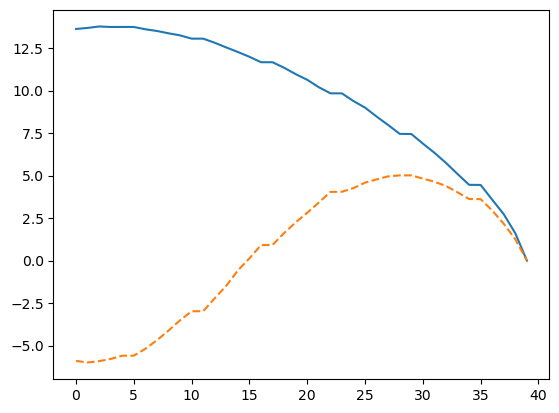

In [48]:
#plot the projected direction
plt.plot(projected_dir_one)
plt.plot(projected_dir_two, linestyle='--')

In [43]:
steps = 30
x_steps = np.linspace(-1/2, 10, steps)
y_steps = np.linspace(-5, 5, steps)

In [44]:
losses = compute_loss_grid(x_steps, y_steps, X_pca, trajectory, resnet, criterion, testloader)
# accuracies = compute_accuracy_grid(x_steps, y_steps, X_pca, trajectory, resnet, testloader)

i: 0, j: 0, loss: 3.2616348266601562
i: 0, j: 1, loss: 3.435678243637085
i: 0, j: 2, loss: 3.450719118118286
i: 0, j: 3, loss: 3.5130369663238525
i: 0, j: 4, loss: 3.4943487644195557
i: 0, j: 5, loss: 3.4926347732543945
i: 0, j: 6, loss: 3.3036696910858154
i: 0, j: 7, loss: 3.2319488525390625
i: 0, j: 8, loss: 3.1332802772521973
i: 0, j: 9, loss: 2.989776611328125
i: 0, j: 10, loss: 2.9681198596954346
i: 0, j: 11, loss: 3.0780484676361084
i: 0, j: 12, loss: 3.266296863555908
i: 0, j: 13, loss: 3.482287883758545
i: 0, j: 14, loss: 3.5150156021118164
i: 0, j: 15, loss: 3.432154417037964
i: 0, j: 16, loss: 3.432054042816162
i: 0, j: 17, loss: 3.3584914207458496
i: 0, j: 18, loss: 3.413689613342285
i: 0, j: 19, loss: 3.4555740356445312
i: 0, j: 20, loss: 3.518524646759033
i: 0, j: 21, loss: 3.5294642448425293
i: 0, j: 22, loss: 3.3731861114501953
i: 0, j: 23, loss: 3.1127407550811768
i: 0, j: 24, loss: 2.9774694442749023
i: 0, j: 25, loss: 2.8533406257629395
i: 0, j: 26, loss: 2.8216087818

KeyboardInterrupt: 

In [24]:
plot_optimization_path_3d(accuracies.T, x_steps, y_steps, projected_dir_one, projected_dir_two, pca)

In [23]:
plot_optimization_path_3d(losses.T, x_steps, y_steps, projected_dir_one, projected_dir_two, pca)

In [112]:
plot_optimization_path_3d(losses.T, x_steps, y_steps, projected_dir_one, projected_dir_two, pca)